# Multilateration in 2D: IoT/LoRaWAN Mass Surveillance
"*Multilateration (MLAT) is a surveillance technique based on the measurement of the difference in distance to two stations at known locations by broadcast signals at known times.*" - [en.wikipedia.org/wiki/Multilateration](http://en.wikipedia.org/wiki/Multilateration)

## Abstract
A single motivated individual with several hundred USD and a hobbyist level of competency in electronics and programming would be able to set up a mass surveillance system to track individual LoRa IoT devices on the scale of a small city, provided that the geography of the city is accommodating to the placement of receiving devices (e.g. surrounded by hills).

## Locating the source of a signal transmission

When a signal is transmitted by a radio device it propagates through the atmosphere at approximately the speed of light - that is, approximately $v = 3 \text{e} 8ms^{-1}$. 

If this signal is received by two receivers (towers), the time difference of arrival ($\text{TDOA}$) between the first and second tower can be determined. $\text{TDOA} = t_1 - t_0$ where $t_0$ is the time the signal is received first and $t_1$ is the time the signal is received second. The towers require synchronized high accuracy clocks, which can be achieved in practice with a GPS clock on each tower.

The below animation shows a signal propagating from a transmitter "Tx" and being received by two towers at different times, allowing the $\text{TDOA}$ to be calculated.

<img src="animations/tdoa.gif" align="middle">

This $\text{TDOA}$ can be used to determine the *difference* in distance that the transmitter is located from the towers. For example, assume that the transmitter is on a circle of radius $d$ metres from tower 1, where the signal was received first. Then it must also be on a circle of radius $d+v \times \text{TDOA}$ metres from tower 0, where the signal was received second. The device must then lie at the intersection of the two circles, giving two possible locations (or one if the circles only touch, or none if the circles do not touch).

By iterating over a range of values for $d$ and at each iteration finding the intersection of the two circles, a locus of possible transmitter locations can be determined. This produces a hyperbolic curve on which the transmitter lies. Notably, it is not required to know *when* the signal was first transmitted - as you would with trilateration - and so no communication with the transmitter is required beyond simply identifying the signal.

The below animation shows circles of increasing radius around the two towers and the resulting hyperbolic locus of intersections as $d$ is increased. The circle around tower 1 has a radius of $r_1=d$, and the circle around tower 0 has a radius of $r_0=d+\text{TDOA} \times v$ (noting $\text{TDOA} \times v$ is constant and $\text{TDOA}$ comes from the previous animation). 

![](animations/locus.gif)

With $n$ towers, this process can be repeated between the tower that first received the message and every other tower to produce $n-1$ loci. In general, with three towers the device location can be narrowed down to at least two positions and with four towers to exactly one position. There are some cases, depending on the relative geometry of the towers and transmitter and the error in the timestamping, where this is not the case.

![](animations/loci.gif)

The accuracy of the determined location will depend on the accuracy of the timestamping, the effects of diffraction and obstacles on path length, the relative geometry of the transmitter and towers, etc. The approximation of the problem to two dimensions will also introduce error.

## Implications: IoT and LoRaWAN

Multilateration can be used to locate the source of a transmission if 
1. the transmission can be received in several locations, and 
2. the receive time can be accurately recorded at each location.

Furthermore, if one transmitter's signal contains a persistent and unencrypted transmitter ID then it will be possible to track the location of that device.

One emerging IoT technology, LoRa/LoRaWAN, allows these requirements to be satisfied cheaply with hobbyist equipment while also transmitting a pseudo-persistent unencrypted device ID. Every device in a LoRaWAN network is given a 32-bit device address - akin to an IPv4 or IPv6 address - that uniquely identifies it on a network. This address is not globally unique, but is unique within a single LoRaWAN network. This address is assigned by the network operator and can be re-assigned at any time, though typically the same address is used for a substantial length of time, making the address pseudo-persistent - again akin to an IPv4 or IPv6 address. In cases where the device is activated by personalization, the device will always use the same address.

Sections 4.3.1.6, 4.3.3, and 4.4.2 of the LoRaWAN [specification](./lorawantm_specification_-v1.1.pdf) specify the encryption of uplink messages (messages sent from an IoT device to the network). Notably, the device address (DevAddr) is never encrypted; in fact it is required that the address be known (unencrypted) in order to decrypt the encrypted portions of the message. Any person listening for LoRa transmissions will receive these messages and will be able to read the device address.

LoRa transmissions can typically travel at least 1km, and distances of up to at least 15km can be attained in real-world conditions. As a result, only a low density of receivers need be installed in order to receive all messages over a large geographical area. For example the city of Wellington, New Zealand, is surrounded by hills. A handful of receivers atop, or partway up, some of the hills would be sufficient to cover the entire city. To cover the main portion of the city with three or four overlapping receivers, as required for multilateration, would not be difficult.

LoRa receivers with GPS are cheap - the Dragino LoRa/GPS Shield for Arduino comes with a LoRa module and a GPS module with 10ns timing accuracy and typically sells for about 50 USD. This device is additionally easy to configure and use, with an abundance of resources available online.

## Summary
Given these three points - LoRa messages contain a pseudo-persistent unique ID, LoRa messages can be received over large distances, and LoRa messages can be received and accurately timestamped with cheap hobbyist equipment - there is a very real possibility to create a passive mass surveillance network that tracks individual LoRa devices. This is a severe privacy concern for applications such as vehicle, person (e.g. elderly), and goods tracking.

## This notebook

This notebook presents a small python script that produces a set of loci of possible transmitter locations given a set of towers with locations and signal receive times. Additionally, the code used to create the animations is given.

In [18]:
from multilaterate import get_loci
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# How many towers. All towers recieve the transmission.
num_towers = 4

# Metre length of a square containing the transmitting
# device, centred around (x, y) = (0, 0). Device will be randomly placed
# in this area.
tx_square_side = 5e3

# Metre length of a square containing the towers,
# centred around (x, y) = (0, 0). towers will be randomly placed
# in this area.
rx_square_side = 25e3

# Speed of transmission propogation. Generally equal to speed of 
# light for radio signals.
v = 3e8

# Time at which transmission is performed. Really just useful to
# make sure the code is using relative times rather than depending on one
# of the receive times being zero.
t_0 = 2.5

# Metre increments to radii of circles when generating locus of
# circle intersection.
delta_d = int(100)

# Max distance a transmission will be from the tower that first
# received the transmission. This puts an upper bound on the radii of the
# circle, thus limiting the size of the locus to be near the towers.
max_d = int(20e3)

# Standard deviation of noise added to the
# receive times at the towers. Mean is zero.
rec_time_noise_stdd = 1e-6

# Whether to plot circles that would be
# used if performing trilateration. These are circles that are centred
# on the towers and touch the transmitter site.
plot_trilateration_circles = False

# Whether to plot a straight line
# between every pair of towers. This is useful for visualising the
# hyperbolic loci focal points.
plot_lines_between_towers = False

towers:
 [[ -2006.09826991  -6818.07867897]
 [   101.31584818   8158.92916584]
 [-10893.22757653   3893.40549794]
 [ -8595.14625748   8895.4077718 ]]
tx: [ 731.70475905 2184.19298779]
distances: [ 9409.38151992  6007.90001384 11749.91315762 11490.45489794]
rec_times: [2.50003146 2.50002049 2.50003941 2.50003865]


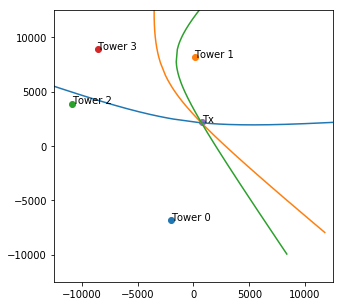

In [43]:
# Generate towers with x and y coordinates.
# for tower i: x, y = towers[i][0], towers[i][1]
towers = (np.random.rand(num_towers, 2)-0.5) * rx_square_side
print('towers:\n', towers)

# location of transmitting device with tx[0] being x and tx[1] being y.
tx = (np.random.rand(2)-0.5) * tx_square_side
print('tx:', tx)

# Distances from each tower to the transmitting device,
# simply triangle hypotenuse.
# distances[i] is distance from tower i to transmitter.
distances = np.array([ ( (x[0]-tx[0])**2 + (x[1]-tx[1])**2 )**0.5
                       for x in towers])
print('distances:', distances)

# Time at which each tower receives the transmission.
rec_times = distances/v + t_0
# Add noise to receive times
rec_times += np.random.normal(loc=0, scale=rec_time_noise_stdd,
                              size=num_towers)
print('rec_times:', rec_times)

# Get the loci.
loci = get_loci(rec_times, towers, v, delta_d, max_d)

# Plot towers and transmission location.
fig, ax = plt.subplots(figsize=(5,5))
max_width = max(tx_square_side, rx_square_side)/2
ax.set_ylim((max_width*-1, max_width))
ax.set_xlim((max_width*-1, max_width))
for i in range(towers.shape[0]):
    x = towers[i][0]
    y = towers[i][1]
    ax.scatter(x, y)
    ax.annotate('Tower '+str(i), (x, y))
ax.scatter(tx[0], tx[1])
ax.annotate('Tx', (tx[0], tx[1]))

# Iterate over every unique combination of towers and plot nifty stuff.
for i in range(num_towers):
    if(plot_trilateration_circles):
        # Circle from tower i to tx site
        circle1 = (towers[i][0], towers[i][1], distances[i])
        circle = plt.Circle((circle1[0], circle1[1]),
                            radius=circle1[2], fill=False)
        ax.add_artist(circle)
    for j in range(i+1, num_towers):
        if(plot_lines_between_towers):
            # Line between towers
            ax.plot((towers[i][0], towers[j][0]),
                    (towers[i][1], towers[j][1]))

for locus in loci:
    ax.plot(locus[0], locus[1])
plt.show()


## Animations
Below cells generate the animations used above. Some variable re-use.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image
from multilaterate import get_locus

# For animation GIF output:
# brew install imagemagick
# brew works on mac, different for different OS I guess.

# If using to_html5_video:
'''
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/Cellar/' \
                                        'ffmpeg/4.0.2/bin/ffmpeg'
'''


towers = np.array([[5e3, 13e3], [16e3, 5e3], [5e3, 7e3],
                   [12.5e3, 1e3]])
tx = np.array([15e3, 8e3])
distances = np.array([ ( (x[0]-tx[0])**2 + (x[1]-tx[1])**2 )**0.5
                       for x in towers])
rec_times = distances/v

v = 3e8
delta_d = 10

In [ ]:
## Create a visualisation for TDOA

# Plot towers and transmission location.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim((0, 20e3))
ax.set_xlim((0, 20e3))
for i in range(2):
    x = towers[i][0]
    y = towers[i][1]
    ax.scatter(x, y)
    ax.annotate('Tower '+str(i), (x, y))
ax.scatter(tx[0], tx[1])
ax.annotate('Tx', (tx[0], tx[1]))

circle = plt.Circle((tx[0], tx[1]),
                    radius=1, fill=False)
ax.add_artist(circle)

# Annotations, to be updated during animation
cur_time = ax.annotate('t = 0', (1e3, 19e3))
t0 = ax.annotate('Tower 0 received at t = ', (1e3, 18e3))
t1 = ax.annotate('Tower 1 received at t = ', (1e3, 17e3))
TDOA_ann = ax.annotate('TDOA = ', (1e3, 16e3))

v_vec = ax.arrow(tx[0], tx[1], 0, 1e3,
                 head_width=500, head_length=500, fc='k', ec='k')
v_ann = ax.annotate('v = {:.0E} m/s'.format(v), (tx[0], tx[1]+1e3))

n_frames = 300
max_seconds = 50e-6

t0_rec = 0
t1_rec = 0
TDOA = 0

def animate(i):
    global t0_rec, t1_rec, TDOA, v_vec, v_ann
    
    t = i/n_frames * max_seconds
    radius = v * t
    
    v_vec.remove()
    v_vec = ax.arrow(tx[0], tx[1]+radius, 0, 1e3,
                 head_width=500, head_length=500, fc='k', ec='k')
    v_ann.set_position((tx[0] - 0.5e3, tx[1]+radius+1.5e3))

    circle.radius = radius
    
    cur_time.set_text('t = {:.2E} s'.format(t))
    
    if(t >= rec_times[0] and t0_rec == 0):
        t0_rec = t
        t0.set_text(t0.get_text() + '{:.2E} s'.format(t0_rec))
    if(t >= rec_times[1] and t1_rec == 0):
        t1_rec = t
        t1.set_text(t1.get_text() + '{:.2E} s'.format(t1_rec))
    if(t0_rec != 0 and t1_rec != 0 and TDOA == 0):
        TDOA = abs(t1_rec-t0_rec)
        TDOA_ann.set_text(TDOA_ann.get_text() \
                          + '{:.2E} s'.format(TDOA))
    
anim = FuncAnimation(fig, animate,
                     frames=n_frames, interval=16.6, blit=False)

# HTML(anim.to_html5_video()) # doesn't play nice with github markdown
anim.save('animations/tdoa.gif', writer='imagemagick', fps=60)
plt.close()
Image(url='animations/tdoa.gif')


In [ ]:
## Create a visualisation for locus

TDOA_dist = v*TDOA

# Plot towers and transmission location.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim((0, 20e3))
ax.set_xlim((0, 20e3))
for i in range(2):
    x = towers[i][0]
    y = towers[i][1]
    ax.scatter(x, y)
    ax.annotate('Tower '+str(i), (x, y))
ax.scatter(tx[0], tx[1])
ax.annotate('Tx', (tx[0], tx[1]))

circle0 = plt.Circle((towers[0][0], towers[0][1]),
                    radius=1e3, fill=False)
circle1 = plt.Circle((towers[1][0], towers[1][1]),
                    radius=1e3, fill=False)
ax.add_artist(circle0)
ax.add_artist(circle1)

# Annotations, to be updated during animation
cur_d_ann = ax.annotate('d = 0', (1e3, 19e3))
r0_ann = ax.annotate('Tower 0 radius r0 = ', (1e3, 18e3))
r1_ann = ax.annotate('Tower 1 radius r1 = ', (1e3, 17e3))

n_frames = 300
max_d = 10e3

locus_plot, = ax.plot([], [], marker=None)

def animate(i):
    # global t0_rec, t1_rec, TDOA, v_vec, v_ann
    
    d = i/n_frames * max_d

    circle0.radius = d + TDOA_dist
    circle1.radius = d
    
    cur_d_ann.set_text('d = {:.2E} m'.format(d))
    r0_ann.set_text('Tower 0 radius r0 = {:.2E} m'.format(d 
                                                + TDOA_dist))
    r1_ann.set_text('Tower 1 radius r1 = {:.2E} m'.format(d))
    
    locus = get_locus(tower_1 = (towers[0][0], towers[0][1]),
                      tower_2 = (towers[1][0], towers[1][1]),
                      time_1 = t0_rec, time_2 = t1_rec,
                      v = v, delta_d = delta_d, max_d=d)
    locus_plot.set_xdata(locus[0])
    locus_plot.set_ydata(locus[1])

anim = FuncAnimation(fig, animate,
                     frames=n_frames, interval=16.6, blit=False)

# HTML(anim.to_html5_video()) # doesn't play nice with github markdown
anim.save('animations/locus.gif', writer='imagemagick', fps=60)
plt.close()
Image(url='animations/locus.gif')

In [ ]:
## Create a visualisation for loci

# Plot towers and transmission location.
fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylim((0, 20e3))
ax.set_xlim((0, 20e3))

for i in range(towers.shape[0]):
    x = towers[i][0]
    y = towers[i][1]
    ax.scatter(x, y)
    ax.annotate('Tower '+str(i), (x, y))
ax.scatter(tx[0], tx[1])
ax.annotate('Tx', (tx[0], tx[1]))

circles = []
locus_plots = []
for i in range(towers.shape[0]):
    circle = plt.Circle((towers[i][0], towers[i][1]),
                         radius=0, fill=False)
    ax.add_artist(circle)
    circles.append(circle)
    
    locus_plot, = ax.plot([], [], marker=None)
    locus_plots.append(locus_plot)

# Annotations, to be updated during animation
cur_d_ann = ax.annotate('d = 0', (1e3, 19e3))

n_frames = 600
max_d = 10e3

def animate(i):
    # global t0_rec, t1_rec, TDOA, v_vec, v_ann
    
    d = i/n_frames * max_d
    cur_d_ann.set_text('d = {:.2E} m'.format(d))
    
    first_tower = int(np.argmin(rec_times))
    circles[first_tower].radius = d
    
    for j in [x for x in range(towers.shape[0]) if x!= first_tower]:
        # print('tower', str(first_tower), 'to', str(j))
        locus = get_locus(tower_1=(towers[first_tower][0],
                                   towers[first_tower][1]),
                          tower_2=(towers[j][0], towers[j][1]),
                          time_1=rec_times[first_tower],
                          time_2=rec_times[j],
                          v=v, delta_d=delta_d, max_d=d)
        locus_plots[j].set_xdata(locus[0])
        locus_plots[j].set_ydata(locus[1])
        
        TDOA_j = v * (rec_times[j] - rec_times[first_tower])
        circles[j].radius = d + TDOA_j

anim = FuncAnimation(fig, animate,
                     frames=n_frames, interval=16.6, blit=False)

# HTML(anim.to_html5_video()) # doesn't play nice with github markdown
anim.save('animations/loci.gif', writer='imagemagick', fps=60)
plt.close()
Image(url='animations/loci.gif')